+ look for shortest and longest posts 
+ count vectorize 
+ find most common words in both 

+ combine into one dataframe 
+ map to 0 1 
+ value counts --> null model 


In [92]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from nltk import FreqDist, pos_tag
from nltk.tokenize import word_tokenize
from collections import Counter

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


## EDA 

In [93]:
# reading in clean dataframes 

def load_clean_data(filename):
    full_file = '../datasets/' + filename + '.csv'
    df = pd.read_csv(full_file)
    return df

In [94]:
vikings = load_clean_data('vikings_clean')

In [95]:
vikings.head()

,label,merged,tokens
0,vikings,"want to hate rodgers,but be just seems like ...","['want', 'to', 'hate', 'rodgers', 'but', 'be',..."
1,vikings,"alright im bored, what are some good games to ...","['alright', 'im', 'bored', 'what', 'are', 'som..."
2,vikings,"cb update going in to week 17, gladney ranks ...","['cb', 'update', 'going', 'in', 'to', 'week', ..."
3,vikings,"cb update going in to week 17, gladney ranks ...","['cb', 'update', 'going', 'in', 'to', 'week', ..."
4,vikings,the over 30 club which players will be 30 in ...,"['the', 'over', '30', 'club', 'which', 'player..."


In [96]:
vikings.shape

(200, 3)

In [97]:
johnprine = load_clean_data('prine_clean')

In [98]:
johnprine.head()

,label,merged,tokens
0,prine,bill murray on john prine,"['bill', 'murray', 'on', 'john', 'prine']"
1,prine,it's my cake day listen to john prine for me ...,"['it', 's', 'my', 'cake', 'day', 'listen', 'to..."
2,prine,here's a pic of my son next to a pic of my unc...,"['here', 's', 'a', 'pic', 'of', 'my', 'son', '..."
3,prine,"1110 s 1st ave maywood, il 60153","['1110', 's', '1st', 'ave', 'maywood', 'il', '..."
4,prine,got this original pressing of bruised orange i...,"['got', 'this', 'original', 'pressing', 'of', ..."


In [99]:
johnprine.shape

(200, 3)

#### Inspecting common words and posts lengths in separate dataframes

In [100]:
def vectorize_and_plot(df, text_field):
    cvec = CountVectorizer(stop_words='english')
    col = df[text_field]
    cvec.fit(col)
    col = cvec.transform(col)
    plot_df = pd.DataFrame(col.todense(),
                          columns=cvec.get_feature_names())
    plot_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

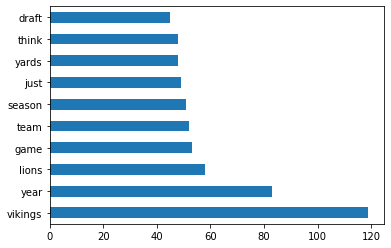

In [101]:
vectorize_and_plot(vikings, 'merged')

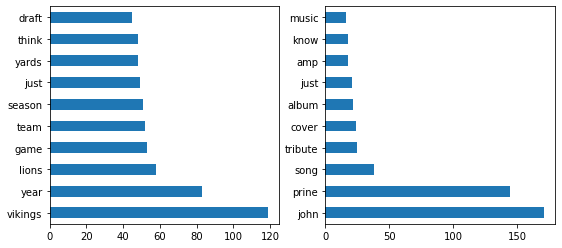

In [102]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
vectorize_and_plot(vikings, 'merged')
plt.subplot(132)
vectorize_and_plot(johnprine, 'merged')

In [135]:
# code inspired by Emmanuel 
# line of code for extracting name from DataFrame to print it and use it as plot title is from this stack overflow page: 
# https://stackoverflow.com/questions/54137694/how-to-print-dataframe-name-in-title-of-a-plot

def post_length_distribution(df):
    
    #getting size of vocabulary 
    all_words = [word for tokens in df['tokens'] for word in tokens]    # getting all the words in the posts
    post_lengths = [len(tokens) for tokens in df['tokens']]    # getting length of the all the posts
    vocab = sorted(list(set(all_words)))    # getting the list of unique words in the corpus composed of the subreddit posts
    
    df_name = [x for x in globals() if globals()[x] is df][0]
    print(f'Post Lengths for {df_name.capitalize()} dataset:')
    
    print(f'{len(all_words)} words total, with a vocabulary size of {len(vocab)}')
    print(f'Max post length is {max(post_lengths)} words')
    print(f'Average post length is {np.mean(post_lengths).round(2)} words') 
    
    # plotting distribution 
    fig = plt.figure(figsize=(6,6))
    plt.xlabel('Post Length')
    plt.ylabel('Number of Posts')
    plt.title(df_name.capitalize())
    plt.hist(post_lengths, bins=100, range=[0, 1500])
    plt.show()
    


Post Lengths for Vikings dataset:
120242 words total, with a vocabulary size of 42
Max post length is 25035 words
Average post length is 601.21 words


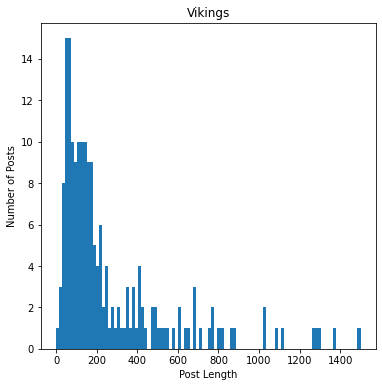

In [136]:
post_length_distribution(vikings)

46476 words total, with a vocabulary size of 42
Max post length is 4762 words
Average post length is 232.38 words


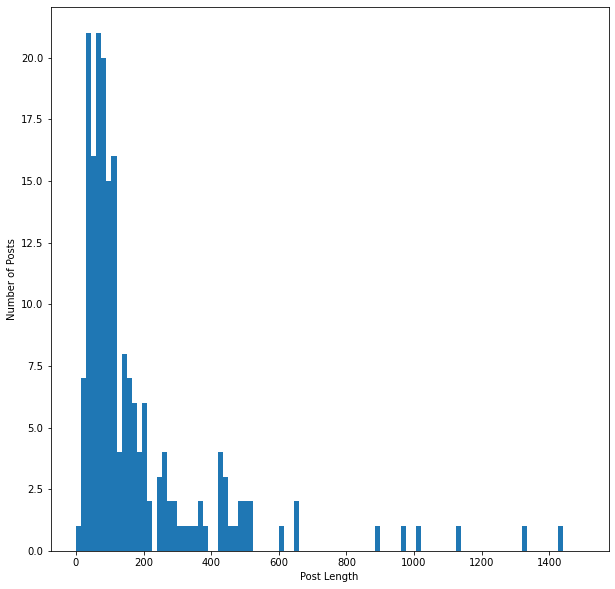

In [137]:
post_length(johnprine)

In [47]:
# def remove_large_small(df, text_field):
#     post_lengths = [len(tokens) for tokens in df['tokens']] # getting length of the all the posts
#     for val in df[text_field]:
#         if val > 

#### Removing long and short posts 

Below function will remove the longest and shortest posts from a dataframe since having a disproportionate number of words come from the same person/post might add unnecessary redundancy that does not reflect the entire corpus. 

**Longest posts:** 

`df['tokens'].map(lambda x: len(x)).nlargest(10)` 

**Shortest posts:**

`df['tokens'].map(lambda x: len(x)).nsmallest(20)`

    or:
   
`df[df['tokens'].str.split().str.len() < 5`


_Inspect results from longest and shortest posts functions above._ 

+ If one or more posts appears to be longer by multiple times or orders of magnitude, remove the row containing that post using the index numbers displayed.  

```
df.drop([idx], inplace=True)
```


+ Remove very short posts as follows: 

```
df = df[df['tokens'].str.split().str.len() > 5]
```


+ Rerun `post_length_distribution` function following this process to see how distribution has changed.  

In [61]:
vikings['tokens'].map(lambda x: len(x)).nlargest(10)

111    25526
132    11789
197     6307
148     5724
74      3250
11      2868
23      2712
18      2418
72      2173
55      2045
Name: tokens, dtype: int64

In [62]:
vikings.drop([111, 132], inplace=True)

In [64]:
vikings[vikings['tokens'].str.split().str.len() < 5]

,label,merged,tokens
48,vikings,I’m conflicted,"['I', 'm', 'conflicted']"
58,vikings,Some awesome football helmets,"['Some', 'awesome', 'football', 'helmets']"
67,vikings,Maybe next year guys,"['Maybe', 'next', 'year', 'guys']"
79,vikings,Courtney Cronin on Twitter,"['Courtney', 'Cronin', 'on', 'Twitter']"
92,vikings,Plz,['Plz']
117,vikings,BRING BACK 96 QUESTIONS,"['BRING', 'BACK', '96', 'QUESTIONS']"
143,vikings,Viking Wall/Shelf,"['Viking', 'Wall', 'Shelf']"
147,vikings,Meanwhile in FTP land...,"['Meanwhile', 'in', 'FTP', 'land']"
165,vikings,Laquon Treadwell TD!! [removed],"['Laquon', 'Treadwell', 'TD', 'removed']"
193,vikings,JJETS✈️ on Twitter,"['JJETS', 'on', 'Twitter']"


In [65]:
vikings = vikings[vikings['tokens'].str.split().str.len() > 5]

In [66]:
vikings.shape

(183, 3)

84710 words total, with a vocabulary size of 73
Max post length is 6307 words
Average post length is 462.9 words


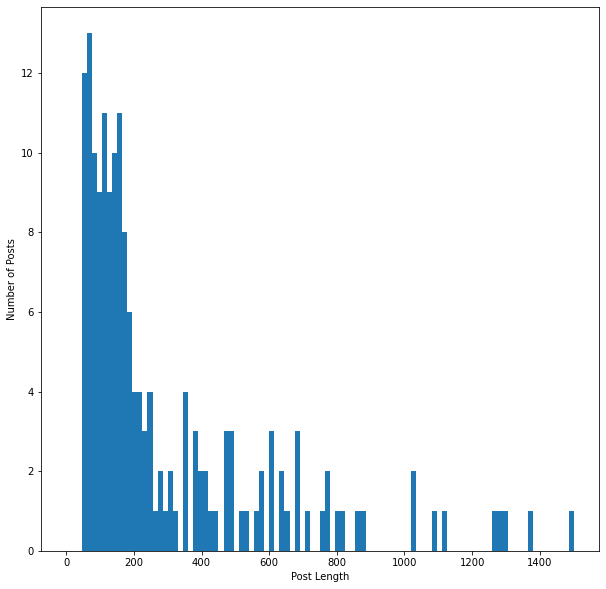

In [67]:
post_length_distribution(vikings)

In [138]:
johnprine['tokens'].map(lambda x: len(x)).nlargest(10)

32     4762
44     2530
118    2312
82     1632
76     1430
25     1327
74     1126
38     1015
35      971
120     885
Name: tokens, dtype: int64

## Model Prep 

#### Combining DataFrames 

don't forget null model! 

In [74]:
def model_df(subreddit_1, subreddit_2):
    
    model_df = pd.concat([subreddit_1, subreddit_2])
    
    # resetting index
    model_df.reset_index(drop=True, inplace=True)
    
    model_df['label'] = model_df['label'].map({subreddit_1: 0, subreddit_2: 1})
    
    # save concatenated datadframe to csv file 
    filename = 'subreddit_1' + '_' + 'subredit_2' + '.csv'
    model_df.to_csv('../datasets/' + filename, index=False)
    
    return model_df